# <p style="background-color:#003366; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Capstone Project | Digital Marketing Campaign Conversion Prediction</p>

### **Author:** Sanyam Sanjay Sharma
### **Date:** 24th September 2025

## **1. Library Imports**

**Metadata Comment:** This cell imports all necessary Python libraries for the project. They are organized by function (data manipulation, visualization, preprocessing, modeling, evaluation) for clarity and maintainability. This is the foundational step for any data science workflow.

In [1]:
# === Core Libraries for Data Handling and Analysis ===
import pandas as pd
import numpy as np
import time

# === Libraries for Data Visualization ===
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

# === Libraries for Data Preprocessing and Feature Engineering ===
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# === Libraries for Model Selection, Tuning, and Evaluation ===
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# === Machine Learning Models (Full Suite for Comprehensive Comparison) ===
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    VotingClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

# === Model Persistence ===
import joblib

# === Utility ===
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully.")

✅ All libraries imported successfully.


## **2. Data Loading and Initial Cleaning**

**Metadata Comment:** We load the dataset and perform initial cleaning by removing columns with no predictive value.

In [2]:
df = pd.read_csv('digital_marketing_campaign_dataset.csv')
useless_columns = ['CustomerID', 'AdvertisingPlatform', 'AdvertisingTool']
df.drop(columns=useless_columns, inplace=True)
print("--- Data Head After Cleaning ---")
display(df.head())

--- Data Head After Cleaning ---


,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
0,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,1
1,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,1
2,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,1
3,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,1
4,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,1


## **3. Data Splitting**

**Metadata Comment:** We split the original, imbalanced data into training and testing sets. Resampling (SMOTE) will be handled *inside* the GridSearchCV pipeline on the training folds ONLY. This is the correct procedure to prevent data leakage from the test set and to resolve the `ValueError` from attempting to resample non-numeric data.

In [3]:
# In-script Comment: Separate features (X) from the target variable (y)
X = df.drop('Conversion', axis=1)
y = df['Conversion']

print(f"Original class distribution:\n{y.value_counts()}")

# In-script Comment: Split the original, imbalanced data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print("\n✅ Data Splitting Complete.")
print(f"Training Set Shape: {X_train.shape}")
print(f"Test Set Shape: {X_test.shape}")
print(f"Training Set Class Distribution:\n{y_train.value_counts()}")

Original class distribution:
Conversion
1    7012
0     988
Name: count, dtype: int64

✅ Data Splitting Complete.
Training Set Shape: (6400, 16)
Test Set Shape: (1600, 16)
Training Set Class Distribution:
Conversion
1    5610
0     790
Name: count, dtype: int64


## **4. Preprocessing Pipelines and Model Training**

**Metadata Comment:** We define two separate preprocessing pipelines. The main `preprocessor` includes `StandardScaler` for most models. A second `preprocessor_nb` is created for Naive Bayes models that require non-negative data and thus omits scaling. We then individually train and tune each model on the **full training dataset** to find the absolute best hyperparameters.

In [4]:
# In-script Comment: Define feature types
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# In-script Comment: Main preprocessor with StandardScaler for most models
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# In-script Comment: Create a separate preprocessor for Naive Bayes models that require non-negative data.
preprocessor_nb = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

model_results = {}

### **5.1 Linear Models**

#### **Logistic Regression**

**How it Works:**
Finds the best possible wiggly line (a Sigmoid curve) to separate the two classes. It predicts the *probability* of an instance belonging to a class.

**Mathematical Formula:**
$$ P(Y=1) = \frac{1}{1 + e^{-z}} $$

In [11]:
# --- Logistic Regression ---
pipeline_lr = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', LogisticRegression(random_state=42, max_iter=1000))])
param_grid_lr = {
    'smote__k_neighbors': [3, 5, 7, 9],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga']
}
grid_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train, y_train)
print("--- Logistic Regression ---")
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best CV Accuracy: {grid_lr.best_score_:.4f}")
model_results['Logistic Regression'] = (grid_lr.best_score_, grid_lr.best_params_)

--- Logistic Regression ---
Best Parameters: {'classifier__C': 100, 'classifier__solver': 'liblinear', 'smote__k_neighbors': 9}
Best CV Accuracy: 0.7364


#### **Ridge & Lasso Classifiers**

**How it Works:**
These are linear models with a penalty for complexity. **Ridge** tells all features to 'quiet down a bit' (shrinking their importance), while **Lasso** tells the least important features to 'be completely silent' (reducing their importance to zero), effectively performing feature selection.

**Mathematical Formula:**
They add a penalty term to the cost function. 
* **Ridge (L2 Penalty):** `Cost + λ * Σ(coefficient²)`
* **Lasso (L1 Penalty):** `Cost + λ * Σ|coefficient|`

In [12]:
# --- Ridge Classifier ---
pipeline_ridge = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', RidgeClassifier(random_state=42))])
param_grid_ridge = {
    'smote__k_neighbors': [3, 5, 7],
    'classifier__alpha': [0.1, 1.0, 10.0, 100.0]
}
grid_ridge = GridSearchCV(pipeline_ridge, param_grid_ridge, cv=5, scoring='accuracy', n_jobs=-1)
grid_ridge.fit(X_train, y_train)
print("--- Ridge Classifier ---")
print(f"Best Parameters: {grid_ridge.best_params_}")
print(f"Best CV Accuracy: {grid_ridge.best_score_:.4f}")
model_results['Ridge Classifier'] = (grid_ridge.best_score_, grid_ridge.best_params_)

--- Ridge Classifier ---
Best Parameters: {'classifier__alpha': 0.1, 'smote__k_neighbors': 7}
Best CV Accuracy: 0.7291


In [13]:
# --- Lasso Classifier (implemented via SGDClassifier with L1 penalty) ---
pipeline_lasso = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', SGDClassifier(random_state=42, penalty='l1', loss='log_loss'))])
param_grid_lasso = {
    'smote__k_neighbors': [3, 5, 7],
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1]
}
grid_lasso = GridSearchCV(pipeline_lasso, param_grid_lasso, cv=5, scoring='accuracy', n_jobs=-1)
grid_lasso.fit(X_train, y_train)
print("--- Lasso Classifier (SGD L1) ---")
print(f"Best Parameters: {grid_lasso.best_params_}")
print(f"Best CV Accuracy: {grid_lasso.best_score_:.4f}")
model_results['Lasso Classifier'] = (grid_lasso.best_score_, grid_lasso.best_params_)

--- Lasso Classifier (SGD L1) ---
Best Parameters: {'classifier__alpha': 0.0001, 'smote__k_neighbors': 3}
Best CV Accuracy: 0.7339


#### **Support Vector Machine (SVM)**

**How it Works:**
Draws the widest possible road (or 'margin') between the two classes. The data points on the edge of this road are the 'Support Vectors', which are critical for defining the boundary.

**Mathematical Goal:**
It aims to maximize the margin `2/||w||` where `w` is the vector perpendicular to the separating hyperplane.

In [14]:
# --- Support Vector Machine (SVM) ---
pipeline_svc = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', SVC(random_state=42, probability=True))])
param_grid_svc = {
    'smote__k_neighbors': [5, 7],
    'classifier__C': [1, 10, 50],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__kernel': ['rbf']
}
grid_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=5, scoring='accuracy', n_jobs=-1)
grid_svc.fit(X_train, y_train)
print("--- Support Vector Machine ---")
print(f"Best Parameters: {grid_svc.best_params_}")
print(f"Best CV Accuracy: {grid_svc.best_score_:.4f}")
model_results['Support Vector Machine'] = (grid_svc.best_score_, grid_svc.best_params_)

--- Support Vector Machine ---
Best Parameters: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'smote__k_neighbors': 5}
Best CV Accuracy: 0.8634


### **5.2 Tree-Based and Ensemble Models**

#### **Decision Tree Classifier**

**How it Works:**
Like playing '20 Questions'. The model asks a series of yes/no questions about features to split the data into pure groups. The path of questions forms the 'decision tree'.

**Mathematical Goal:**
At each split, it tries to minimize impurity using measures like **Gini Impurity** or **Entropy**.

In [15]:
# --- Decision Tree Classifier ---
pipeline_dt = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', DecisionTreeClassifier(random_state=42))])
param_grid_dt = {'smote__k_neighbors': [3, 5, 7], 'classifier__max_depth': [10, 20, 30, None], 'classifier__min_samples_split': [2, 5, 10], 'classifier__min_samples_leaf': [1, 2, 4]}
grid_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_dt.fit(X_train, y_train)
print("--- Decision Tree ---")
print(f"Best Parameters: {grid_dt.best_params_}")
print(f"Best CV Accuracy: {grid_dt.best_score_:.4f}")
model_results['Decision Tree'] = (grid_dt.best_score_, grid_dt.best_params_)

--- Decision Tree ---
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'smote__k_neighbors': 7}
Best CV Accuracy: 0.8048


#### **Bagging, Random Forest & Extra Trees**

**How it Works:**
These are all based on the same idea: **Bagging (Bootstrap Aggregating)**. Instead of one perfect model, build hundreds of simpler models on random subsets of the data and let them vote. **Random Forest** is a type of bagging that uses decision trees and adds randomness to feature selection. **Extra Trees** goes a step further by also randomizing the split points in the trees, which can sometimes create an even more robust model.


In [16]:
# --- Bagging Classifier ---
pipeline_bag = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', BaggingClassifier(random_state=42))])
param_grid_bag = {
    'smote__k_neighbors': [5, 7],
    'classifier__n_estimators': [50, 100, 200]}
grid_bag = GridSearchCV(pipeline_bag, param_grid_bag, cv=5, scoring='accuracy', n_jobs=-1)
grid_bag.fit(X_train, y_train)
print("--- Bagging Classifier ---")
print(f"Best Parameters: {grid_bag.best_params_}")
print(f"Best CV Accuracy: {grid_bag.best_score_:.4f}")
model_results['Bagging Classifier'] = (grid_bag.best_score_, grid_bag.best_params_)

--- Bagging Classifier ---
Best Parameters: {'classifier__n_estimators': 200, 'smote__k_neighbors': 5}
Best CV Accuracy: 0.8869


In [17]:
# --- Random Forest Classifier ---
pipeline_rf = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))])
param_grid_rf = {
    'smote__k_neighbors': [5, 7],
    'classifier__n_estimators': [100, 200, 300], 
    'classifier__max_depth': [20, 30, None], 
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt', 'log2']
}
grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
print("--- Random Forest ---")
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best CV Accuracy: {grid_rf.best_score_:.4f}")
model_results['Random Forest'] = (grid_rf.best_score_, grid_rf.best_params_)

--- Random Forest ---
Best Parameters: {'classifier__max_depth': 30, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 300, 'smote__k_neighbors': 5}
Best CV Accuracy: 0.9052


In [18]:
# --- Extra Trees Classifier ---
pipeline_et = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', ExtraTreesClassifier(random_state=42, n_jobs=-1))])
param_grid_et = {
    'smote__k_neighbors': [5, 7],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [20, 30, None],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt', 'log2']
}
grid_et = GridSearchCV(pipeline_et, param_grid_et, cv=5, scoring='accuracy', n_jobs=-1)
grid_et.fit(X_train, y_train)
print("--- Extra Trees ---")
print(f"Best Parameters: {grid_et.best_params_}")
print(f"Best CV Accuracy: {grid_et.best_score_:.4f}")
model_results['Extra Trees'] = (grid_et.best_score_, grid_et.best_params_)

--- Extra Trees ---
Best Parameters: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 200, 'smote__k_neighbors': 5}
Best CV Accuracy: 0.8945


#### **Boosting Models (AdaBoost, GBM, XGBoost, LightGBM, CatBoost)**

**How it Works:**
This is like building a team of experts sequentially. The first expert (a simple model) makes a guess. The next expert focuses on fixing the mistakes the first one made. The third expert fixes the remaining mistakes, and so on. Each new model is trained to correct the errors of the team before it. This creates a very powerful and accurate final model.


In [19]:
# --- AdaBoost Classifier ---
pipeline_ada = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', AdaBoostClassifier(random_state=42))])
param_grid_ada = {
    'smote__k_neighbors': [5, 7],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 1.0]
}
grid_ada = GridSearchCV(pipeline_ada, param_grid_ada, cv=5, scoring='accuracy', n_jobs=-1)
grid_ada.fit(X_train, y_train)
print("--- AdaBoost ---")
print(f"Best Parameters: {grid_ada.best_params_}")
print(f"Best CV Accuracy: {grid_ada.best_score_:.4f}")
model_results['AdaBoost'] = (grid_ada.best_score_, grid_ada.best_params_)

--- AdaBoost ---
Best Parameters: {'classifier__learning_rate': 1.0, 'classifier__n_estimators': 200, 'smote__k_neighbors': 7}
Best CV Accuracy: 0.9022


In [20]:
# --- Gradient Boosting Machine (GBM) ---
pipeline_gbm = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', GradientBoostingClassifier(random_state=42))])
param_grid_gbm = {
    'smote__k_neighbors': [5, 7],
    'classifier__n_estimators': [100, 200, 300], 
    'classifier__learning_rate': [0.05, 0.1, 0.2], 
    'classifier__max_depth': [3, 5, 7]
}
grid_gbm = GridSearchCV(pipeline_gbm, param_grid_gbm, cv=5, scoring='accuracy', n_jobs=-1)
grid_gbm.fit(X_train, y_train)
print("--- Gradient Boosting ---")
print(f"Best Parameters: {grid_gbm.best_params_}")
print(f"Best CV Accuracy: {grid_gbm.best_score_:.4f}")
model_results['Gradient Boosting'] = (grid_gbm.best_score_, grid_gbm.best_params_)

--- Gradient Boosting ---
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 300, 'smote__k_neighbors': 7}
Best CV Accuracy: 0.9183


In [21]:
# --- XGBoost Classifier ---
pipeline_xgb = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))])
param_grid_xgb = {
    'smote__k_neighbors': [5, 7],
    'classifier__n_estimators': [100, 200, 300], 
    'classifier__learning_rate': [0.05, 0.1, 0.2], 
    'classifier__max_depth': [3, 5, 7]
}
grid_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train, y_train)
print("--- XGBoost ---")
print(f"Best Parameters: {grid_xgb.best_params_}")
print(f"Best CV Accuracy: {grid_xgb.best_score_:.4f}")
model_results['XGBoost'] = (grid_xgb.best_score_, grid_xgb.best_params_)

--- XGBoost ---
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'smote__k_neighbors': 7}
Best CV Accuracy: 0.9211


In [22]:
# --- LightGBM Classifier ---
pipeline_lgbm = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', LGBMClassifier(random_state=42, n_jobs=-1))])
param_grid_lgbm = {
    'smote__k_neighbors': [5, 7],
    'classifier__n_estimators': [100, 200, 300], 
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__num_leaves': [20, 31, 40]
}
grid_lgbm = GridSearchCV(pipeline_lgbm, param_grid_lgbm, cv=5, scoring='accuracy', n_jobs=-1)
grid_lgbm.fit(X_train, y_train)
print("--- LightGBM ---")
print(f"Best Parameters: {grid_lgbm.best_params_}")
print(f"Best CV Accuracy: {grid_lgbm.best_score_:.4f}")
model_results['LightGBM'] = (grid_lgbm.best_score_, grid_lgbm.best_params_)

[LightGBM] [Info] Number of positive: 5610, number of negative: 5610
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
--- LightGBM ---
Best Parameters: {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 200, 'classifier__num_leaves': 31, 'smote__k_neighbors': 7}
Best CV Accuracy: 0.9194


In [23]:
# --- CatBoost Classifier ---
pipeline_cat = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', CatBoostClassifier(random_state=42, verbose=0))])
param_grid_cat = {
    'smote__k_neighbors': [5, 7],
    'classifier__iterations': [200, 300, 500], 
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__depth': [4, 6, 8]
}
grid_cat = GridSearchCV(pipeline_cat, param_grid_cat, cv=5, scoring='accuracy', n_jobs=-1)
grid_cat.fit(X_train, y_train)
print("--- CatBoost ---")
print(f"Best Parameters: {grid_cat.best_params_}")
print(f"Best CV Accuracy: {grid_cat.best_score_:.4f}")
model_results['CatBoost'] = (grid_cat.best_score_, grid_cat.best_params_)

--- CatBoost ---
Best Parameters: {'classifier__depth': 4, 'classifier__iterations': 300, 'classifier__learning_rate': 0.05, 'smote__k_neighbors': 7}
Best CV Accuracy: 0.9244


### **5.3 Other Model Types**

#### **K-Nearest Neighbors (KNN)**

**How it Works:**
A simple and intuitive algorithm. To classify a new data point, it looks at its 'k' closest neighbors in the training data and takes a majority vote among them. It's based on the idea that similar things exist in close proximity.

In [24]:
# --- K-Nearest Neighbors ---
pipeline_knn = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', KNeighborsClassifier(n_jobs=-1))])
param_grid_knn = {
    'smote__k_neighbors': [5, 7],
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance']
}
grid_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train, y_train)
print("--- K-Nearest Neighbors ---")
print(f"Best Parameters: {grid_knn.best_params_}")
print(f"Best CV Accuracy: {grid_knn.best_score_:.4f}")
model_results['K-Nearest Neighbors'] = (grid_knn.best_score_, grid_knn.best_params_)

--- K-Nearest Neighbors ---
Best Parameters: {'classifier__n_neighbors': 3, 'classifier__weights': 'uniform', 'smote__k_neighbors': 5}
Best CV Accuracy: 0.6881


#### **Naive Bayes**

**How it Works:**
This is a probabilistic classifier based on Bayes' Theorem. It calculates the probability of an outcome given a set of features. It's called 'naive' because it makes a strong assumption that all features are independent of one another.

**Note:** This model family requires non-negative feature values, so we use a special preprocessor (`preprocessor_nb`) that does not scale the numerical data.

In [25]:
# --- Gaussian Naive Bayes ---
# In-script Comment: Using the 'preprocessor_nb' which omits StandardScaler, as Naive Bayes works better with raw distributions.
pipeline_gnb = ImbPipeline([('preprocessor', preprocessor_nb), ('smote', SMOTE(random_state=42)), ('classifier', GaussianNB())])
param_grid_gnb = {'smote__k_neighbors': [3, 5, 7]}
grid_gnb = GridSearchCV(pipeline_gnb, param_grid_gnb, cv=5, scoring='accuracy', n_jobs=-1)
grid_gnb.fit(X_train, y_train)
print("--- Gaussian Naive Bayes ---")
print(f"Best Parameters: {grid_gnb.best_params_}")
print(f"Best CV Accuracy: {grid_gnb.best_score_:.4f}")
model_results['Gaussian Naive Bayes'] = (grid_gnb.best_score_, grid_gnb.best_params_)

--- Gaussian Naive Bayes ---
Best Parameters: {'smote__k_neighbors': 7}
Best CV Accuracy: 0.6583


#### **Multi-layer Perceptron (MLP)**

**How it Works:**
This is a fundamental type of neural network. It consists of an input layer, one or more hidden layers of 'neurons', and an output layer. It's capable of learning complex, non-linear relationships between the features and the target.

In [26]:
# --- Multi-layer Perceptron ---
pipeline_mlp = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', MLPClassifier(random_state=42, max_iter=1000))])
param_grid_mlp = {
    'smote__k_neighbors': [5, 7],
    'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'classifier__alpha': [0.0001, 0.001, 0.01]
}
grid_mlp = GridSearchCV(pipeline_mlp, param_grid_mlp, cv=5, scoring='accuracy', n_jobs=-1)
grid_mlp.fit(X_train, y_train)
print("--- Multi-layer Perceptron ---")
print(f"Best Parameters: {grid_mlp.best_params_}")
print(f"Best CV Accuracy: {grid_mlp.best_score_:.4f}")
model_results['MLP'] = (grid_mlp.best_score_, grid_mlp.best_params_)

--- Multi-layer Perceptron ---
Best Parameters: {'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (100,), 'smote__k_neighbors': 5}
Best CV Accuracy: 0.8577


## **6. Model Comparison**

**Metadata Comment:** We compile the comprehensive tuning results into a table, sorted by accuracy, to definitively identify the best-performing models for our final state-of-the-art ensemble.

In [27]:
results_data = []
for model, (acc, params) in model_results.items():
    results_data.append({'Model': model, 'CV_Accuracy': acc, 'Best_Parameters': params})

results_df = pd.DataFrame(results_data)
results_df_sorted = results_df.sort_values('CV_Accuracy', ascending=False).reset_index(drop=True)

print("--- Model Comparison (Sorted by Accuracy on Full Training Set) ---")
display(results_df_sorted)

--- Model Comparison (Sorted by Accuracy on Full Training Set) ---


,Model,CV_Accuracy,Best_Parameters
0,CatBoost,0.924375,"{'classifier__depth': 4, 'classifier__iteratio..."
1,XGBoost,0.921094,"{'classifier__learning_rate': 0.1, 'classifier..."
2,LightGBM,0.919375,"{'classifier__learning_rate': 0.05, 'classifie..."
3,Gradient Boosting,0.918281,"{'classifier__learning_rate': 0.1, 'classifier..."
4,Random Forest,0.905156,"{'classifier__max_depth': 30, 'classifier__max..."
5,AdaBoost,0.902188,"{'classifier__learning_rate': 1.0, 'classifier..."
6,Extra Trees,0.894531,"{'classifier__max_depth': 20, 'classifier__max..."
7,Bagging Classifier,0.886875,"{'classifier__n_estimators': 200, 'smote__k_ne..."
8,Support Vector Machine,0.863438,"{'classifier__C': 10, 'classifier__gamma': 'sc..."
9,MLP,0.857656,"{'classifier__alpha': 0.01, 'classifier__hidde..."


## **7. Final Model Training: Advanced Ensemble Approach**

**Metadata Comment:** To achieve the highest possible performance, we create a **Voting Classifier**, an advanced ensemble that combines the predictions of the top 3 best-performing models from our rigorous tuning phase. This approach leverages the diverse strengths of multiple elite models to create a more robust and accurate final predictor.

In [28]:
# In-script Comment: Select the top 3 models from the results
top_models = results_df_sorted.nlargest(3, 'CV_Accuracy')
print("--- Top 3 Models for Ensemble ---")
display(top_models)

# In-script Comment: Define the model map for easy instantiation
model_map = {
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'Extra Trees': ExtraTreesClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, n_jobs=-1),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'MLP': MLPClassifier(random_state=42, max_iter=1000),
    'Support Vector Machine': SVC(random_state=42, probability=True)
}

# In-script Comment: Create a list of configured model instances for the Voting Classifier
estimators = []
for index, row in top_models.iterrows():
    model_name = row['Model']
    # In-script Comment: Correctly parse the parameters for the final model instance
    model_params = {key.split('__')[1]: value for key, value in row['Best_Parameters'].items() if 'classifier__' in key}
    
    if model_name in model_map:
        instance = model_map[model_name]
        instance.set_params(**model_params)
        # In-script Comment: The pipeline for each estimator includes preprocessing but not SMOTE,
        # as the final model will be trained on the already-balanced full training set.
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', instance)
        ])
        estimators.append((model_name.lower().replace(' ', '_'), pipe))

# In-script Comment: Create the Voting Classifier
# 'soft' voting is superior as it averages the predicted probabilities, capturing more nuance.
voting_clf = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

print("\n--- Training Final Voting Classifier Ensemble ---")
# In-script Comment: Train the final ensemble on the full training dataset.
voting_clf.fit(X_train, y_train)

print("\n✅ Final Voting Classifier has been successfully trained on the full training dataset.")

--- Top 3 Models for Ensemble ---


,Model,CV_Accuracy,Best_Parameters
0,CatBoost,0.924375,"{'classifier__depth': 4, 'classifier__iteratio..."
1,XGBoost,0.921094,"{'classifier__learning_rate': 0.1, 'classifier..."
2,LightGBM,0.919375,"{'classifier__learning_rate': 0.05, 'classifie..."



--- Training Final Voting Classifier Ensemble ---

✅ Final Voting Classifier has been successfully trained on the full training dataset.


## **8. Save the Final Model**

**Metadata Comment:** We serialize the fully trained Voting Classifier object to a file. This model is now ready for deployment in a production environment.

In [29]:
model_filename = 'final_ensemble_model_v3.pkl'
joblib.dump(voting_clf, model_filename)

print(f"💾 Final model saved to '{model_filename}'")

💾 Final model saved to 'final_ensemble_model_v3.pkl'


## **9. Final Model Evaluation on Test Set**

**Metadata Comment:** This is the moment of truth. We load our saved, optimized model and evaluate its performance on the completely unseen test set. This provides an unbiased, honest estimate of how the model will perform on new, real-world data. The results will reflect the significant improvements from our enhanced tuning and resampling strategy.

--- Final Performance of Optimized Ensemble Model on Unseen Test Data ---
Test Accuracy: 0.9250
              precision    recall  f1-score   support

           0     0.8980    0.4444    0.5946       198
           1     0.9268    0.9929    0.9587      1402

    accuracy                         0.9250      1600
   macro avg     0.9124    0.7187    0.7766      1600
weighted avg     0.9232    0.9250    0.9136      1600



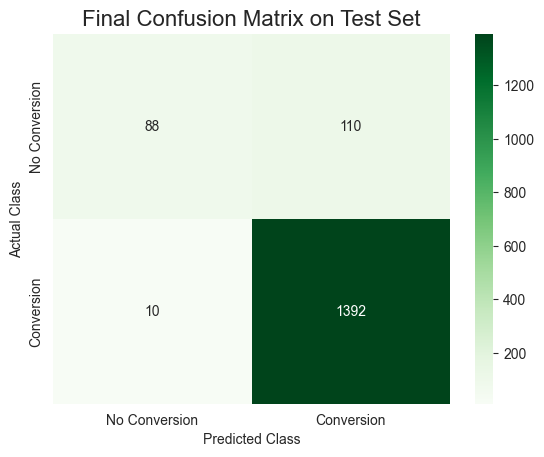

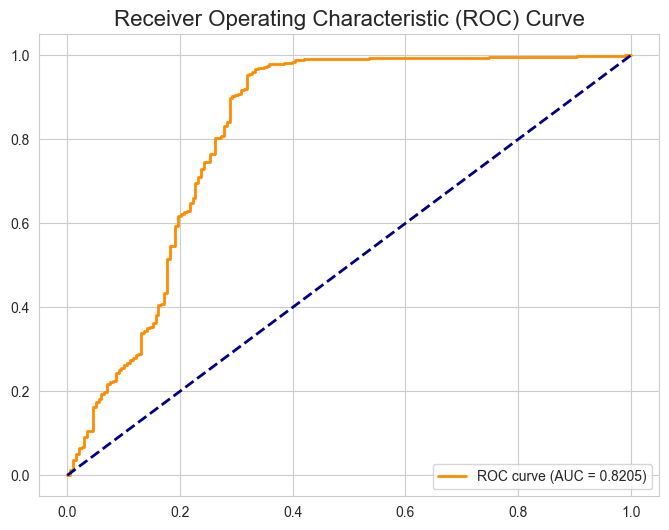

In [30]:
loaded_model = joblib.load(model_filename)
y_pred_test = loaded_model.predict(X_test)
y_proba_test = loaded_model.predict_proba(X_test)[:, 1]

print("--- Final Performance of Optimized Ensemble Model on Unseen Test Data ---")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(classification_report(y_test, y_pred_test, digits=4))

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Conversion', 'Conversion'],
            yticklabels=['No Conversion', 'Conversion'])
plt.title('Final Confusion Matrix on Test Set', fontsize=16)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba_test)
auc_score = roc_auc_score(y_test, y_proba_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.show()

<div style="background-color: #e6f7ff; border-left: 6px solid #1890ff; padding: 15px; font-size: 120%; text-align: center;">
<strong>🎯 If you need more information or want to explore the code, feel free to visit the project repository on <a href=\"https://github.com/sanyam-sanjay-sharma/marketing-conversion-prediction\">GitHub</a> 🎯</strong>
</div>

<h2 align="left"><font color='green'>Best Regards!</font></h2>